In [ ]:
!git clone https://github.com/Harry24k/bayesian-neural-network-pytorch
!pip install torchbnn

fatal: destination path 'bayesian-neural-network-pytorch' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!git clone https://github.com/gregversteeg/NPEET.git
!pip install NPEET/.

fatal: destination path 'NPEET' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Processing ./NPEET
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Installing backend dependencies ... - \ done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for NPEET: filename=NPEET-1.0.1-py3-none-any.whl size=7347 sha256=562a343c391effbcf35a4c383be3c1ef3d7393281fb8d2ed8ee816ce9ccbf42f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p52w5ag_/wheels/24/f4/81/b6ce4d8fdb916c92a29193394ce48f98745a0cc8814661d54e
Successfully built NPEET
  Attempting uninstall: NPEET
    Found existing installation: NPEET 1.0.1
    Uninstalling NPEET-1.0.1:
      Successfully uninstalled NPEET-1.0.1


In [ ]:
import torchbnn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import numpy as np
import torchbnn as bnn
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


# Configuration and Hyperparameters

In [ ]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 1 # batch size must be equal to 1 in this notebook
learning_rate = 0.001


# Load MNIST Dataset

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Model Classes

In [ ]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# Bayesian neural network
class BayesianNeuralNet(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
        super(BayesianNeuralNet, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_size, out_features=num_classes)

      def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
fc_model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [ ]:
bayes_model = BayesianNeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and Optimizers

In [ ]:
# Loss and optimizer
def opt_cri_loss_setter(model):
  criterion = nn.CrossEntropyLoss()
  kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
  fc_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  bayes_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  return fc_optimizer, bayes_optimizer, criterion, kl_loss


In [ ]:
fc_opt, _, fc_criterion, _ = opt_cri_loss_setter(fc_model)
_, bayes_opt, bayes_criterion, kl_loss = opt_cri_loss_setter(bayes_model)

# Plot the Loss

In [ ]:
def loss_plot(losses, x_label, y_label, title):
  k = len(losses)/1000
  tmp_losses = []

  for i in range(int(k)):
    tmp_losses.append(np.array(losses[i*1000:(i+1)*1000]).mean())


  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.plot(np.arange(1000, (len(tmp_losses)+1)*1000, 1000), np.array(tmp_losses))
  plt.show()

# Test Function with Clean Images

In [ ]:
# In the test phase, don't need to compute gradients (for memory efficiency)
def model_tester(model, name):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy of the ' + name + ' network on the 10000 test images: {} %'.format(100 * correct / total))

  # Save the model checkpoint
  # torch.save(model.state_dict(), str(name+'.ckpt'))

# Cold Posterior Effect in Bayesian Neural Networks

### Mutual Information Among Images

In [ ]:
from npeet import entropy_estimators as ee

def mutual_info_calculator(image1, image2):
  return ee.mi(image1, image2)

### Data Augmentation

In [ ]:
from torchvision.transforms.autoaugment import AutoAugmentPolicy
# An Augmentation policy that used for CIFAR10 to produce augmented images

torch.manual_seed(38)
auto_aug_policy = transforms.Compose([
                    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                    transforms.ToTensor(),
                ])

In [ ]:
# Tranformation from tensor to PIL image due to applying AutoAugmentation
trans_t2PIL = transforms.ToPILImage()

# Produce n augmented images from a clean image and associates its mutual info with clean image to it
def augmented_data_producer(clean_image, n):
  image = trans_t2PIL(clean_image)
  augmented_images = []
  mi = []
  clean_image_mi = mutual_info_calculator(clean_image.numpy().reshape(28, 28).tolist(), clean_image.numpy().reshape(28, 28).tolist())
  augmented_images.append(clean_image)
  mi.append(clean_image_mi/clean_image_mi)

  for i in range(1, n):
    augmented_images.append(auto_aug_policy(image))
    mi.append(mutual_info_calculator(clean_image.numpy().reshape(28, 28).tolist(), augmented_images[i].numpy().reshape(28, 28).tolist())/clean_image_mi)
  return augmented_images, mi

# Train the Model Icorporating Data Augmentation




In [ ]:
fc_mean_mi_model = NeuralNet(input_size, hidden_size, num_classes).to(device)
fc_mean_mi_optimizer, _, fc_mean_mi_criterion, _ = opt_cri_loss_setter(fc_mean_mi_model)

bayes_aug_model = BayesianNeuralNet(input_size, hidden_size, num_classes).to(device)
_, bayes_aug_optimizer, bayes_aug_criterion, kl_loss_aug = opt_cri_loss_setter(bayes_aug_model)


In [ ]:
def model_trainer_incorporating_DA(model, criterion, optimizer, kl_loss=kl_loss, kl_weight = 0.01, CPE=False, HPE=False, fixed_T=False, T=0.01, bayesian=False, number_of_augmentations=20):
  total_step = len(train_loader)
  losses = []
  cumulative_loss = 0
  for epoch in range(num_epochs):
      for i, (image, label) in tqdm(enumerate(train_loader)):
          # Produce n augmented images for each image in dataset
          augmented_images, mutual_info = augmented_data_producer(image.reshape(1, 28, 28), number_of_augmentations)

          # Move tensors to the configured device
          clean_images = image.reshape(-1, 28*28).to(device)
          label = label.to(device)

          # Forward pass for each augmented image of clean image
          for augmented_image, mi in zip(augmented_images, mutual_info):
            img = augmented_image.reshape(-1, 28*28).to(device)
            m_i = torch.tensor(mi).to(device)
            outputs = model(img)

            # If T is not a predefined value, then according to CPE, HPE, bayesian loss will be one of the following values:
            if not fixed_T:
              if not bayesian and not CPE and not HPE:
                loss = criterion(outputs, label)
              elif not bayesian and CPE and not HPE:
                loss = torch.pow(criterion(outputs, label),(1./m_i))
              elif not bayesian and not CPE and HPE:
                loss = torch.pow(criterion(outputs, label),m_i)
              elif bayesian and not CPE and not HPE:
                loss = criterion(outputs, label) + (kl_weight*kl_loss(model))
              elif bayesian and CPE and not HPE:
                loss = torch.pow(criterion(outputs, label),(1./m_i)) + (kl_weight*kl_loss(model))
              elif bayesian and not CPE and HPE:
                loss = torch.pow(criterion(outputs, label), m_i) + (kl_weight*kl_loss(model))

            # if the T is a predefined value:
            elif fixed_T:
              if not bayesian:
                loss = torch.pow(criterion(outputs, label),(1./T))
              elif bayesian:
                loss = torch.pow(criterion(outputs, label),(1./T)) + (kl_weight*kl_loss(model))

            cumulative_loss += loss.item()

            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          if (i+1) % batch_size == 0:
              # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              losses.append(cumulative_loss/number_of_augmentations)
              cumulative_loss = 0
      print ('Epoch [{}/{}], Average Loss: {:.4f}'
                    .format(epoch+1, num_epochs, np.array(losses[epoch*total_step:(epoch+1)*total_step]).mean()))

  return losses

In [ ]:
fc_mean_mi_losses = model_trainer_incorporating_DA(fc_mean_mi_model, fc_mean_mi_criterion, fc_mean_mi_optimizer, kl_weight=1, CPE=False, HPE=False, fixed_T=True, T=0.25, bayesian=False, number_of_augmentations=20)

60000it [5:09:02,  3.24it/s]


Epoch [1/5], Average Loss: 205914598.9402


60000it [4:54:41,  3.39it/s]


Epoch [2/5], Average Loss: 2481542166.8149


60000it [4:48:17,  3.47it/s]


Epoch [3/5], Average Loss: 3314557312.1659


60000it [4:25:02,  3.77it/s]


Epoch [4/5], Average Loss: 4867823228.5574


60000it [4:29:38,  3.71it/s]

Epoch [5/5], Average Loss: 7866714016.7410


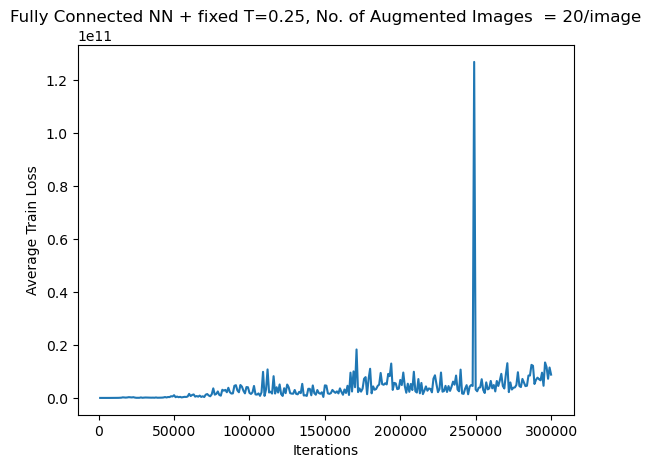

In [ ]:
loss_plot(fc_mean_mi_losses, "Iterations", "Average Train Loss","Fully Connected NN + fixed T=0.25, No. of Augmented Images  = 20/image")

In [ ]:
bayes_aug_losses = model_trainer_incorporating_DA(bayes_aug_model, bayes_aug_criterion, bayes_aug_optimizer, kl_weight=1, kl_loss=kl_loss_aug, CPE=False, HPE=False, fixed_T=False, bayesian=True, number_of_augmentations=20)

60000it [6:30:28,  2.56it/s]


Epoch [1/5], Average Loss: 0.9637


60000it [6:26:00,  2.59it/s]


Epoch [2/5], Average Loss: 0.9686


60000it [6:26:12,  2.59it/s]


Epoch [3/5], Average Loss: 0.9716


60000it [6:28:01,  2.58it/s]


Epoch [4/5], Average Loss: 0.9780


60000it [6:27:21,  2.58it/s]

Epoch [5/5], Average Loss: 0.9770


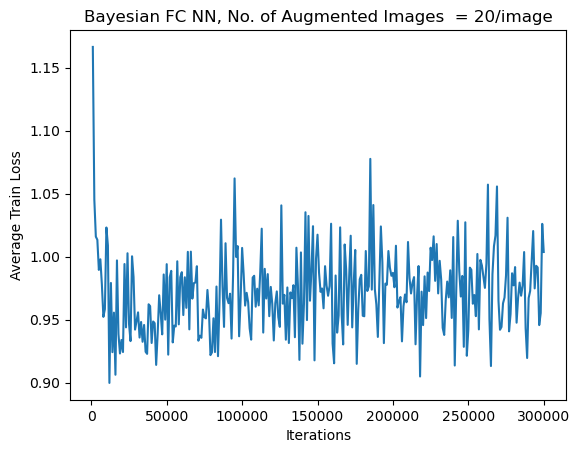

In [ ]:
loss_plot(bayes_aug_losses, "Iterations", "Average Train Loss","Bayesian FC NN, No. of Augmented Images  = 20/image")

## Test the Models

### Test With Clean Images

In [ ]:
model_tester(fc_mean_mi_model, "FullyConnected_mean_mi")

Accuracy of the FullyConnected_mean_mi network on the 10000 test images: 93.01 %


In [ ]:
model_tester(bayes_aug_model, "Bayesian_FC_Aug")

Accuracy of the Bayesian_FC_Aug network on the 10000 test images: 74.15 %


### Test With Augmentes Images

In [ ]:
# Test with just Augmented Images;
# In the test phase, don't need to compute gradients (for memory efficiency)
def model_tester_augmentes_images(model, name):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          aug_img, _ = augmented_data_producer(images.reshape(1, 28, 28), 10)
          image = aug_img[random.randint(1, 9)].reshape(-1, 28*28).to(device)
          label = labels.to(device)
          outputs = model(image)
          _, predicted = torch.max(outputs.data, 1)
          total += label.size(0)
          correct += (predicted == label).sum().item()

      print('Accuracy of the ' + name + ' network on the 10000 test images: {} %'.format(100 * correct / total))

  # Save the model checkpoint
  # torch.save(model.state_dict(), str(name+'.ckpt'))

In [ ]:
model_tester_augmentes_images(fc_mean_mi_model, "FullyConnected_mean_mi")

Accuracy of the FullyConnected_mean_mi network on the 10000 test images: 86.43 %


In [ ]:
model_tester_augmentes_images(bayes_aug_model, "Bayesian_FC_Aug")

Accuracy of the Bayesian_FC_Aug network on the 10000 test images: 66.06 %
